In [356]:
# This file aimed to trined on a LSTM based on different power and threshould and
# see if it works.
from DataPrepocessing import *
from NeuralNets import *
from TrainMethod import *

import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
from functools import partial


In [357]:
model = SimpleLSTM()

(612, 833)


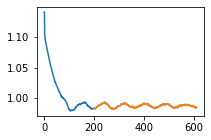

In [358]:
# read the data and only keep the stable state
plt.figure(figsize=(3,2))
raw_data_P1T1 = pd.read_csv("./data/Tracked Files/P1T1.csv")
raw_data_P1T1.fillna(0, inplace= True)
plt.plot(raw_data_P1T1.iloc[:,1])
cut_data_P1T1 = raw_data_P1T1[200:]
plt.plot(cut_data_P1T1.iloc[:,1])
print(raw_data_P1T1.shape)

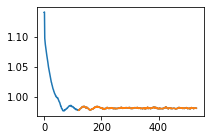

In [359]:
raw_data_P1T09 = pd.read_csv("./data/Tracked Files/P1T0.9.csv")
raw_data_P1T09.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
data = raw_data_P1T09
plt.plot(data.iloc[:,1])
cut_data_P1T09 = data[120:]
plt.plot(cut_data_P1T09.iloc[:,1])

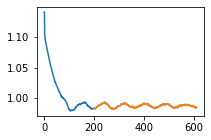

In [360]:
raw_data_P06T1 = pd.read_csv("./data/Tracked Files/P0.6T1.csv")
raw_data_P06T1.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
plt.plot(raw_data_P06T1.iloc[:,1])
cut_data_P06T1 = raw_data_P06T1[200:]
plt.plot(cut_data_P06T1.iloc[:,1])

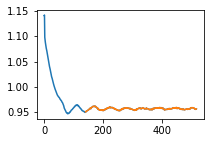

In [361]:
raw_data_P1T11 = pd.read_csv("./data/Tracked Files/P1T1.1.csv")
raw_data_P1T11.fillna(0, inplace= True)
plt.figure(figsize=(3,2))
plt.plot(raw_data_P1T11.iloc[:,1])
cut_data_P1T11 = raw_data_P1T11[140:]
plt.plot(cut_data_P1T11.iloc[:,1])

In [362]:
# now we get all the stable data
print(len(cut_data_P1T1))
print(len(cut_data_P1T11))
print(len(cut_data_P06T1))
print(len(cut_data_P1T09))

# first, cut the data according to the sequence length
sequence_length = 10

time_cut = lambda data : data[: len(data)//sequence_length * sequence_length]

cut_data_P1T11 = time_cut(cut_data_P1T11)
cut_data_P1T1 = time_cut(cut_data_P1T1)
cut_data_P06T1 = time_cut(cut_data_P06T1)
cut_data_P1T09 = time_cut(cut_data_P1T09)

# drop the first timestamp column (OR should we keep it?)

drop_first = lambda data : data.iloc[:, 1:]

cut_data_P1T11 = drop_first(cut_data_P1T11)
cut_data_P1T1 = drop_first(cut_data_P1T1)
cut_data_P06T1 = drop_first(cut_data_P06T1)
cut_data_P1T09 = drop_first(cut_data_P1T09)




print(len(cut_data_P1T1))
print(len(cut_data_P1T11))
print(len(cut_data_P06T1))
print(len(cut_data_P1T09))

412
376
412
413
410
370
410
410


In [363]:
cut_data_P06T1.columns # whether should keep the keff_relative_uncertainty

Index(['keff [/]', 'keff_relative_uncertainty [/]', 'Cs137_0 [at/b.cm]',
       'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]', 'Cs137_3 [at/b.cm]',
       'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]', 'Cs137_6 [at/b.cm]',
       'Cs137_7 [at/b.cm]',
       ...
       'Cs137_820 [at/b.cm]', 'Cs137_821 [at/b.cm]', 'Cs137_822 [at/b.cm]',
       'Cs137_823 [at/b.cm]', 'Cs137_824 [at/b.cm]', 'Cs137_825 [at/b.cm]',
       'Cs137_826 [at/b.cm]', 'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]',
       'Cs137_829 [at/b.cm]'],
      dtype='object', length=832)

In [364]:
# this function move the keff from the first column to the last
def move_labels(df):
    # move the first column to the last column
    cols = list(df.columns)
    # df = df.iloc[:, 1:] # select all rows and columns except the first one
    df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end
    return df


In [365]:
cut_data_P1T11 = move_labels(cut_data_P1T11)
cut_data_P1T1 = move_labels(cut_data_P1T1)
cut_data_P06T1 = move_labels(cut_data_P06T1)
cut_data_P1T09 = move_labels(cut_data_P1T09)

C:\Users\86182\AppData\Local\Temp\ipykernel_19272\3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end
C:\Users\86182\AppData\Local\Temp\ipykernel_19272\3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols[0]] = df.pop(cols[0]) # remove the first column and append it to the end
C:\Users\86182\AppData\Local\Temp\ipykernel_19272\3494102704.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result

In [366]:
cut_data_P06T1.columns

Index(['keff_relative_uncertainty [/]', 'Cs137_0 [at/b.cm]',
       'Cs137_1 [at/b.cm]', 'Cs137_2 [at/b.cm]', 'Cs137_3 [at/b.cm]',
       'Cs137_4 [at/b.cm]', 'Cs137_5 [at/b.cm]', 'Cs137_6 [at/b.cm]',
       'Cs137_7 [at/b.cm]', 'Cs137_8 [at/b.cm]',
       ...
       'Cs137_821 [at/b.cm]', 'Cs137_822 [at/b.cm]', 'Cs137_823 [at/b.cm]',
       'Cs137_824 [at/b.cm]', 'Cs137_825 [at/b.cm]', 'Cs137_826 [at/b.cm]',
       'Cs137_827 [at/b.cm]', 'Cs137_828 [at/b.cm]', 'Cs137_829 [at/b.cm]',
       'keff [/]'],
      dtype='object', length=832)

In [367]:
hist_data_P1T11 = generate_histogram(cut_data_P1T11.to_numpy())
hist_data_P1T1 = generate_histogram(cut_data_P1T1.to_numpy())
hist_data_P06T1 = generate_histogram(cut_data_P06T1.to_numpy())
hist_data_P1T09 = generate_histogram(cut_data_P1T09.to_numpy())

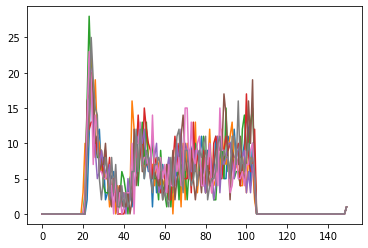

In [368]:
for i in range(1, 400,50):
    plt.plot(hist_data_P06T1[i][1:])

In [369]:
print(hist_data_P06T1.shape)
print(hist_data_P1T09.shape)
print(hist_data_P1T1.shape)
print(hist_data_P1T11.shape)

(410, 151)
(410, 151)
(410, 151)
(370, 151)


In [370]:
def add_one_column (arr,new_col_value):
    # Create a new column of single value to add to the front of the array
    new_col = np.full((arr.shape[0]), new_col_value)

    # Use insert to insert the new column to the front of the array
    new_arr = np.insert(arr, 0, new_col, axis=1)

    return new_arr

def add_Power_and_Threshold(arr, p = 1, t = 1):
    arr = add_one_column(arr, p)
    arr = add_one_column(arr, t)

    return arr

In [371]:
x = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
print(add_one_column(x, 0))

[[0 1 2 3]
 [0 4 5 6]
 [0 7 8 9]]


In [372]:
# final_data_P1T11 = hist_data_P1T11
# final_data_P1T1 = hist_data_P1T1
# final_data_P06T1 = hist_data_P06T1
# final_data_P1T09 = hist_data_P1T09


final_data_P1T11 = add_Power_and_Threshold(hist_data_P1T11,1,1.1)
final_data_P1T1 = add_Power_and_Threshold(hist_data_P1T1,1,1)
final_data_P06T1 = add_Power_and_Threshold(hist_data_P06T1,0.6,1)
final_data_P1T09 = add_Power_and_Threshold(hist_data_P1T09,1,0.9)

In [373]:
print(final_data_P06T1.shape)
print(final_data_P1T1.shape)
print(final_data_P1T09.shape)
print(final_data_P1T11.shape)

(410, 153)
(410, 153)
(410, 153)
(370, 153)


In [374]:
# the lowest is in the testing set
all_data = np.concatenate((final_data_P06T1, final_data_P1T09, final_data_P1T1,final_data_P1T11), axis=0)
# the lowest is in the training set
all_data = np.concatenate((final_data_P06T1, final_data_P1T11,final_data_P1T09, final_data_P1T1), axis=0)
print(all_data.shape)

(1600, 153)


In [375]:
# normalize the p and t

from sklearn.preprocessing import StandardScaler
# do the data preprossing
data = all_data

ss = StandardScaler()

data = ss.fit_transform(data)


clean_data = data.copy()


In [376]:
# do not normalize the p and t

# from sklearn.preprocessing import StandardScaler
# # do the data preprossing
# data = all_data[:,2:]

# ss = StandardScaler()

# data = ss.fit_transform(data)

# data = np.concatenate((all_data[:, :2], data), axis=1)


# clean_data = data.copy()

In [377]:
data[0][0]

0.03582871819482519

In [378]:
data.shape

(1600, 153)

In [379]:
all_data.shape

(1600, 153)

In [380]:
training_data = ReactorData(data,10,0,0.75)
testing_data = ReactorData(data,10,0.75,1)

In [381]:
# define neural nets

input_dim = training_data[0][0].shape[1]



# print(output_dim)

# some adjustable hyper-parameters
nets_hyper_parameters = {
'input_dim' : input_dim,
'output_dim' : 1,
'hidden_dim' : 64,
'lstm_nums_layer' : 2,
'dropout' : 0.2 
}


model = SimpleLSTM(**nets_hyper_parameters)

In [382]:
optimizer_parameters = {
    'params':model.parameters(),
    'lr' : 0.01,
    'weight_decay' : 0.01
}

train_parameters = {
    'model' : model,
    'training_data' : training_data,
    'epoch_num': 200,
    'batch_size':16,
    'optimizer' : optim.Adam(**optimizer_parameters),
    'loss_fn' : nn.MSELoss(),
    'print_out_frequency': 20

}


model, _ = train(** train_parameters)

The loss is 0.06064869118643618 in epoch 0
The loss is 0.011446639813043318 in epoch 20
The loss is 0.007123014323898865 in epoch 40
The loss is 0.015547221385583124 in epoch 60
The loss is 0.07886367093686301 in epoch 80
The loss is 0.024238390912463458 in epoch 100
The loss is 0.01157928718333891 in epoch 120
The loss is 0.01448062331069298 in epoch 140
The loss is 0.008527874484098063 in epoch 160
The loss is 0.03060374309109608 in epoch 180
Training is finished, the final loss is 0.012339072020226683


In [383]:
# visualize the training output
def show(data, model):
    import matplotlib.pyplot as plt


    X = (torch.tensor(data.unshaped_data)).double()
    y = (torch.tensor(data.unshaped_labels)).double()


    plt.figure()
    plt.xlabel('Timestamp')
    plt.ylabel('Keff')
    plt.plot(y, label = "Real")     
    plt.plot(model(X).detach().numpy(), label = "Predict")
    plt.legend()


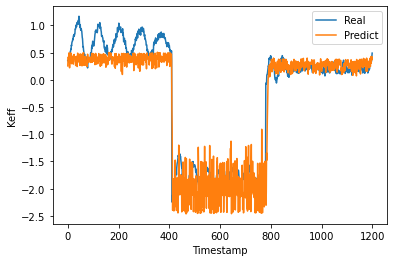

In [384]:
show(training_data, model)

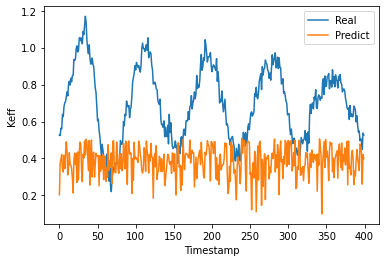

In [385]:
show(testing_data, model)


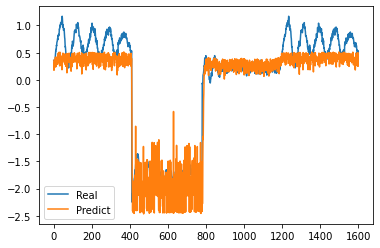

In [386]:
# view all data together
import matplotlib.pyplot as plt


X = (torch.tensor(data[:,:-1])).double()
y = (torch.tensor(data[:,-1:])).double()


plt.figure()
plt.plot(y, label = "Real")     
plt.plot(model(X).detach().numpy(), label = "Predict")
plt.legend()

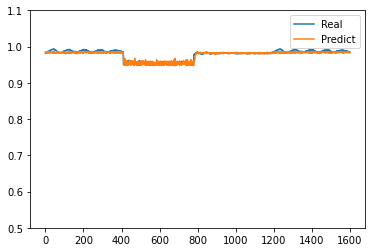

In [387]:
# view all data in the original format
import matplotlib.pyplot as plt


X = (torch.tensor(data[:,:-1])).double()
y = (torch.tensor(data[:,-1:])).double()

# result_y = np.concatenate((X[:,2:], y), axis=1)
# result_predict = np.concatenate((X[:,2:], model(X).detach().numpy()), axis=1)

result_y = np.concatenate((X, y), axis=1)
result_predict = np.concatenate((X, model(X).detach().numpy()), axis=1)

y = ss.inverse_transform(result_y)
predict = ss.inverse_transform(result_predict)

plt.figure()
plt.ylim((0.5,1.1))
plt.plot(y[:,-1], label = "Real")     
plt.plot(predict[:,-1], label = "Predict")
plt.legend()